In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy.integrate as spi
import h5py
import os

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import merger_tree_tools as mtt
import snapshot_tools as st
import halo_tools as ht
import galaxy_tools as gt
import profile_tools as pt

mtt=reload(mtt)
st=reload(st)
ht=reload(ht)
gt=reload(gt)

In [2]:
data_directory = '/fred/oz009/cpower/TheThreeHundred/'
# datasets_to_process = [2, 3, 4, 5, 6, 8, 9, 16, 38] 
datasets_to_process = [1, 322] 
snapshots = []
halos = []

for i in datasets_to_process:
    dataset_dir = f'NewMDCLUSTER_{i:03d}'
    snapshot_path = os.path.join(data_directory, dataset_dir, 'snap_128')
    halo_catalog_path = os.path.join(data_directory, dataset_dir, f'GIZMO_7k-{dataset_dir}.snap_128.z0.000')

    snap = st.SnapshotTools(snapshot_path, '3')
    halo = ht.HaloTools(halo_catalog_path, 'AHF')

    snap.ReadSnapshot()
    snap.UnitConversion(convert_to_physical=False, convert_to_littleh=False)
    halo.ReadHaloCatalogue()
    snap.LoadParticlesByType('all')

    snapshots.append(snap)
    halos.append(halo)

    print(f"已处理数据集：{dataset_dir}")

Reading data from /fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_001/snap_128.hdf5
Simulation scale factor: 1.000000
Number of particles: 0131819696
Number of particle types: 6
/fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_001/GIZMO_7k-NewMDCLUSTER_001.snap_128.z0.000.AHF_halos
已处理数据集：NewMDCLUSTER_001
Reading data from /fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_322/snap_128.hdf5
Simulation scale factor: 1.000000
Number of particles: 0067696738
Number of particle types: 6
/fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_322/GIZMO_7k-NewMDCLUSTER_322.snap_128.z0.000.AHF_halos
已处理数据集：NewMDCLUSTER_322


In [3]:
profiles=pt.ProfileTools()

ihalo=0
numbins=100
radius_min=0.05*halo.GroupR200[ihalo]
radius_max=10.0*halo.GroupR200[ihalo]
radial_limits=[radius_min,radius_max]
fsize=1
size=fsize*halo.GroupR200[ihalo]
centre=halo.GroupPos[ihalo]
lbox=snap.BoxSize
# rhonorm=27.755
rhonorm=5.1250226e-10

/tmp/ipykernel_2615634/4197318111.py:19: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(r_dm/size,np.log10(density),color='black',linewidth=2, linestyle='-', label='binned')


2.4165660370436437
2.4219148981657246


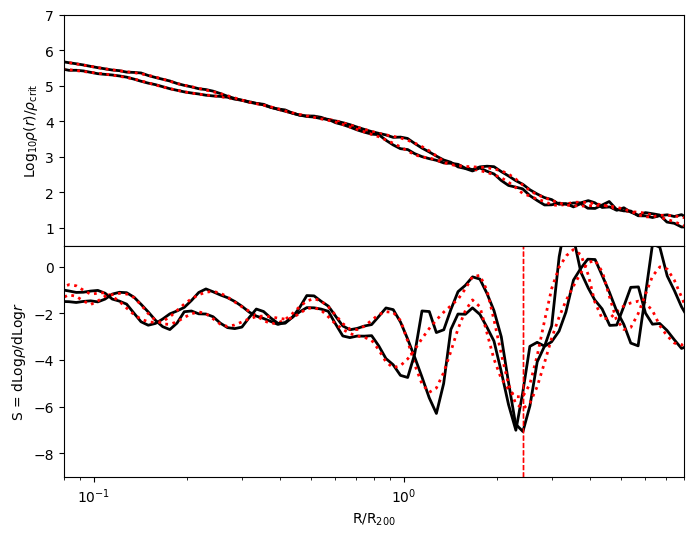

In [4]:
# Get DM density profile
M200=[]
Rsp=[]

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for i in range(2):
    M200.append(halos[i].GroupM200[ihalo])
    radius_min=0.05*halos[i].GroupR200[ihalo]
    radius_max=10.0*halos[i].GroupR200[ihalo]
    radial_limits=[radius_min,radius_max]
    size=fsize*halos[i].GroupR200[ihalo]
    centre=halos[i].GroupPos[ihalo]
    numbins=100
    r_dm,density=profiles.plot_mass_density_profile(snapshots[i].dm.pos,snapshots[i].dm.mass,centre,20*fsize*size,lbox,radial_limits,numbins,geometry='spherical',type='average')
    density = density/rhonorm
    ax1.plot(r_dm/size,np.log10(density),color='black',linewidth=2, linestyle='-', label='binned')
    smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    ax1.plot(r_dm/size,np.log10(smoothed_density),color='r',linewidth=2, linestyle='dotted', label='smoothed')

    smoothed_density = savgol_filter(density, window_length=15, polyorder=4, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(r_dm/size)
    d_log_D = np.gradient(log_D, log_r)   
    ax2.plot(r_dm / size, d_log_D, color='black', linestyle='-', linewidth=2.0)
    smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    ax2.plot(r_dm / size, smoothed_d_log_D, color='r', linestyle='dotted', linewidth=2.0)

    restricted_indices = np.where((r_dm / size >= 0.2) & (r_dm / size <= 5))[0]
    r_dm_restricted = r_dm[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = r_dm_restricted[r_splash_index] / size
    ax2.axvline(x=r_splash, color='r', linestyle='--', linewidth=1.0)
    Rsp.append(r_splash)
    print(r_splash)

ax1.set_ylabel(r'${\rm Log}_{10} \rho(r)/\rho_{\rm crit}$')
ax1.set_xscale('log')
ax1.set_xlim(0.08,8)
ax1.set_ylim(0.5,7)
# ax1.legend()

ax2.set_xlabel(r'${\rm R/R}_{200}$')
ax2.set_ylabel(r'S = ${\rm d Log} \rho / {\rm d Log} r$')
ax2.set_xscale('log')
ax2.set_xlim(0.08,8)
ax2.set_ylim(-9,0.9)
np.savetxt('./data/M200.txt', M200, fmt='%s')
np.savetxt('./data/Rsp.txt', Rsp, fmt='%s')
# plt.savefig("./figures/DM_splashback_radius_1.png")

/fred/oz009/mzhang/anaconda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/fred/oz009/mzhang/anaconda/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2.3343350241130647
3.1587490302949583


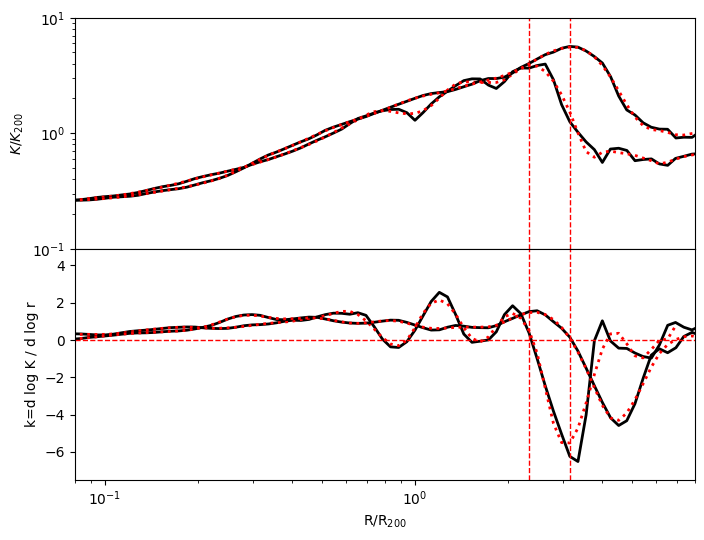

In [5]:
Rsh=[]
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(2):
    pos=snapshots[i].gas.pos-halos[i].GroupPos[ihalo]
    r=np.sqrt(pos[:,0]**2+pos[:,1]**2+pos[:,2]**2)
    keep_ids=np.where(r<halos[i].GroupR200[ihalo])

    entropy = np.mean( 1/ (snapshots[i].gas.density[keep_ids])**(2/3) * snapshots[i].gas.internal_energy[keep_ids])
    e200 = entropy
    
    # gas entropy profiles
    radius_min=0.05*halos[i].GroupR200[ihalo]
    radius_max=20.0*halos[i].GroupR200[ihalo]
    radial_limits=[radius_min,radius_max]
    size=fsize*halos[i].GroupR200[ihalo]
    centre=halos[i].GroupPos[ihalo]
    numbins=100
    rgav_1,umed_av=profiles.plot_mass_density_profile(snapshots[i].gas.pos,1/(snapshots[i].gas.density)**(2/3)*snapshots[i].gas.internal_energy,centre,20*fsize*size,lbox,radial_limits,numbins,geometry='spherical',type='average_T')
    ax1.plot(rgav_1/size, umed_av / e200,color='black',linewidth=2, linestyle='-', label='binned')
    smoothed_entropy = savgol_filter(umed_av / e200, window_length=15, polyorder=4, deriv=0, delta=0.1)
    ax1.plot(rgav_1/size, smoothed_entropy,color='r',linewidth=2, linestyle='dotted',label='smoothed')

    # entropy_profiles.append(umed_av / e200)
    log_K = np.log10(smoothed_entropy)
    log_r = np.log10(rgav_1 / size)
    d_log_K = np.gradient(log_K, log_r)
    ax2.plot(rgav_1 / size, d_log_K, color='black', linewidth=2.0)
    
    smoothed_d_log_D = savgol_filter(d_log_K, window_length=15, polyorder=4, deriv=0, delta=0.1)
    ax2.plot(rgav_1 / size, savgol_filter(d_log_K,window_length=15,polyorder=4,deriv=0,delta=0.1), color='r',linestyle='dotted', linewidth=2.0)
    
    r_range_mask = (rgav_1/size >= 0.1) & (rgav_1/size <= 5)
    rgav_1_in_range = rgav_1[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]
        ax1.axvline(x=r_shock/size, color='r', linestyle='--', linewidth=1)
        ax2.axvline(x=r_shock/size, color='r', linestyle='--', linewidth=1)
    print(r_shock/size)
    Rsh.append(r_shock/size)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax1.set_ylabel(r'$K/K_{200}$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.08,8)
ax1.set_ylim(0.1,10)
# ax1.legend()

ax2.set_xlabel(r'${\rm R/R}_{200}$')
ax2.set_ylabel(r'k=d log K / d log r')
ax2.set_xscale('log')
ax2.set_xlim(0.08,8)
ax2.set_ylim(-7.5,4.9)
np.savetxt('./data/Rsh.txt', Rsh, fmt='%s')
# plt.savefig("./figures/Gas_shock_radius_1.png")